### **Modified version (generate random windows during train)**

#### **imports**

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy, os, torch, glob 
import torch, torchaudio
from scipy.fft import fft, fftfreq
from pynwb import NWBHDF5IO
from scipy.io import wavfile
import torch, whisper 
import torch
import torch.nn as nn

whisper_model = whisper.load_model("base")   # tiny, small, base, etc.
whisper_encoder = whisper_model.encoder              # this is the part you want
from whisper.audio import log_mel_spectrogram
mel_fn = log_mel_spectrogram
hilbert3 = lambda x: scipy.signal.hilbert(x, scipy.fftpack.next_fast_len(len(x)),axis=0)[:len(x)]

def extractHG_modified(data, sr):
    #Linear detrend
    orig_data = scipy.signal.detrend(data, axis=0)
    #Filter High-Gamma Band
    sos = scipy.signal.iirfilter(4, [70/(sr/2),170/(sr/2)],btype='bandpass',output='sos')
    data = scipy.signal.sosfiltfilt(sos,orig_data,axis=0)
    #Attenuate first harmonic of line noise
    sos = scipy.signal.iirfilter(4, [98/(sr/2),102/(sr/2)],btype='bandstop',output='sos')
    data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    # Attenuate second harmonic of line noise 
    sos = scipy.signal.iirfilter(4, [148/(sr/2),152/(sr/2)],btype='bandstop',output='sos')
    data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    data = np.abs(hilbert3(data)) # this is the envelop amplitude
    # lowpass filter original signal to get the low-frequency signals (supposedly they are important for synthesis)
    sos = scipy.signal.iirfilter(6, 30/(sr/2), btype='lowpass', output='sos')
    data_extra = scipy.signal.sosfiltfilt(sos, orig_data, axis = 0)
    # concatenated_data = np.concatenate([data, data_extra], axis = -1)\
    concatenated_data = data 
    sr_new = 100 # to make it the same as the mel spectrogram 
    total_channels = concatenated_data.shape[1]
    new_data_length = int(np.floor(concatenated_data.shape[0]*sr_new/sr))
    eeg_feat = np.zeros((new_data_length, concatenated_data.shape[1]))
    for i in range(total_channels): # no. of channels
        tmp = scipy.signal.resample(concatenated_data[:, i], new_data_length) 
        eeg_feat[:, i] = tmp
    return eeg_feat

def whisper_log_mel_spectrogram(audio: torch.Tensor, n_mels: int = 80) -> torch.Tensor:
    if audio.dim() == 2:
        audio = audio.mean(dim=0)  # convert stereo → mono
    elif audio.dim() != 1:
        raise ValueError("Audio tensor must be 1D or 2D (channels, samples)")
    sample_rate = 16000
    n_fft = 400
    hop_length = 160
    win_length = 400
    f_min = 0
    f_max = 8000
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window_fn=torch.hann_window,
        n_mels=n_mels,
        f_min=f_min,
        f_max=f_max,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm=None,
        mel_scale="htk"
    )
    mel = mel_transform(audio)
    log_mel = torch.clamp(mel, min=1e-10).log10()
    log_mel_numpy = log_mel.numpy() 
    return log_mel_numpy

#### **save eeg and mel to .npy files**

In [124]:
path_bids = '/home/shahed/public_datasets/Dutch_Dataset'
MAX_WAV_VALUES  = []
file_list = [f"/home/shahed/public_datasets/Dutch_Dataset/sub-{i:02d}/ieeg/sub-{i:02d}_task-wordProduction_events.tsv" 
                for i in range(1, 11)]

participants = pd.read_csv(os.path.join(path_bids,'participants.tsv'), delimiter='\t')
for p_id, participant in enumerate(participants['participant_id']): 
    # if p_id not in [2]:
    #     continue 
    io = NWBHDF5IO(os.path.join(path_bids,participant,'ieeg',f'{participant}_task-wordProduction_ieeg.nwb'), 'r')
    nwbfile = io.read()
    eeg = nwbfile.acquisition['iEEG'].data[:]; eeg_sr = 1024
    eeg_duration = eeg.shape[0]/eeg_sr
    print(f'sEEG length in seconds: {eeg_duration}')
    audio = nwbfile.acquisition['Audio'].data[:]; orig_audio_sr = 48000 
    audio_sr = 16000 # for Whisper
    audio = scipy.signal.resample(audio, int(len(audio)*audio_sr/orig_audio_sr))
    audio = audio / np.max(np.abs(audio) + 1e-9) ## normalize audio
    audio = audio.astype(np.float32)

    audio_duration = audio.shape[0]/audio_sr
    print(f'audio length in seconds: {audio_duration}')
    io.close()
    min_duration = min(audio_duration, eeg_duration)
    audio = audio[:int(min_duration*audio_sr)] ## mono audio
    eeg = eeg[:int(min_duration*eeg_sr), :]

    #Extract HG features
    feat = extractHG_modified(eeg, eeg_sr)
    print(f'eeg feature shape: {feat.shape}') 
    
    audio_torch = torch.from_numpy(audio).float()  

    # audio: torch tensor [48000] for 3s at 16 kHz
    mel = mel_fn(audio_torch)      # [80, T] typically T = 300
    mel = mel.T              # [T, 80]

    print(f'whisper mel spectrogram shape : {mel.shape}')

    mel_numpy = mel.numpy()

    # print("mel mean:", mel.mean().item())
    # print("mel std:", mel.std().item())
    # print("mel min:", mel.min().item())
    # print("mel max:", mel.max().item())


    np.save(f'/home/shahed/SSIP/data/eeg/eeg_sub_{p_id}.npy', feat)
    np.save(f'/home/shahed/SSIP/data/mel/mel_sub_{p_id}.npy', mel_numpy)


/home/shahed/.venv/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shahed/.venv/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shahed/.venv/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


sEEG length in seconds: 300.3037109375
audio length in seconds: 300.30275
eeg feature shape: (30030, 127)
whisper mel spectrogram shape : torch.Size([30030, 80])
sEEG length in seconds: 300.30859375
audio length in seconds: 300.31075
eeg feature shape: (30030, 127)
whisper mel spectrogram shape : torch.Size([30030, 80])
sEEG length in seconds: 300.3154296875
audio length in seconds: 300.3136875
eeg feature shape: (30031, 127)
whisper mel spectrogram shape : torch.Size([30031, 80])
sEEG length in seconds: 300.3134765625
audio length in seconds: 300.315125
eeg feature shape: (30031, 115)
whisper mel spectrogram shape : torch.Size([30031, 80])
sEEG length in seconds: 300.2900390625
audio length in seconds: 300.2928125
eeg feature shape: (30029, 60)
whisper mel spectrogram shape : torch.Size([30029, 80])
sEEG length in seconds: 300.384765625
audio length in seconds: 300.3905625
eeg feature shape: (30038, 127)
whisper mel spectrogram shape : torch.Size([30038, 80])
sEEG length in seconds: 3

#### **define the dataloaders and dataset classes**

In [2]:
from torch.utils.data import Dataset, DataLoader
import random 

# Define the custom dataset class
class sEEG_Dataset(Dataset): 
    def __init__(self, X, y, T, sr=100, n_segments_per_epoch=640, augment = True):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.sr = sr; self.T = T
        self.n_segments = n_segments_per_epoch
        self.augment = augment 
    def __len__(self):
        return self.n_segments # each epoch will draw n_segments_per_epoch random crops
    def __getitem__(self, idx):
        # Random start index for cropping
        # start = random.randint(0, self.X.shape[0] - self.T*self.sr) ## self.X.shape[0] is the total length of the sample
        start_idx = random.randint(0, self.X.shape[0]//(self.T*self.sr)) # pick from 0 to T_big
        start = start_idx * self.sr # this ensures that we surely pick an example that starts with speech
        end = start + self.sr*self.T
        # Crop the same segment from both
        mel = self.X[start:end] 
        sEEG = self.y[start:end]
        if self.augment:
            if random.random() < 0.5:
                noise = (0.316)*torch.randn(size = mel.shape, dtype=torch.float32) # variance of 0.1
                mel = mel + noise 
        return mel, sEEG 
    
class sEEG_EvalDataset(Dataset):
    def __init__(self, X, y, T, sr=100):
        self.X = X.to(dtype=torch.float32)
        self.y = y.to(dtype=torch.float32)
        self.sr = sr
        self.seg_len = int(T * sr)
        self.total_len = X.shape[0]
        # Number of full contiguous segments
        if (self.total_len - (self.total_len//self.seg_len)*self.seg_len > self.seg_len//2):
            self.n_segments = self.total_len // self.seg_len + 1 ## add zeros to match the
        else:
            self.n_segments = self.total_len // self.seg_len 
    def __len__(self):
        return self.n_segments
    def __getitem__(self, idx):
        start = idx * self.seg_len
        end = min(start + self.seg_len, self.X.shape[0]) ## the last segment might be a bit smaller!
        mel = self.X[start:end]
        sEEG = self.y[start:end]
        return mel, sEEG

#### **model arch. and dataset classes**

In [31]:
T = 2
SUB_IDX = 0

class TemporalCNN_deep(nn.Module):
    def __init__(self, input_channels=127, output_size=80, kernel_size = [9,9,9], dilations=[3,3,3], conv_params=None):
        super(TemporalCNN_deep, self).__init__()
        # Default convolutional parameters if none are provided
        if conv_params is None:
            conv_params = [
                (128, kernel_size[0], dilations[0], 0),  # (out_channels, kernel_size, dilation, dropout_rate)
                (256, kernel_size[1], dilations[1], 0),
                (512, kernel_size[2], dilations[2], 0)
                ## (512, 15, 7, 0.5)
            ]
        self.total_channels = conv_params[-1][0]
        self.conv_blocks = nn.ModuleList()
        in_channels = input_channels
        for out_channels, kernel_size, dilation, dropout_rate in conv_params:
            conv_block = nn.Sequential(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    padding='same'  # Ensures output length = input length
                ),
                nn.BatchNorm1d(out_channels),
                nn.GELU(),
                # squeeze_and_excite(out_channels),
                nn.Dropout(dropout_rate)
            )
            self.conv_blocks.append(conv_block)
            in_channels = out_channels  # Update input channels for the next block
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.total_channels, self.total_channels//2),  # in_channels is the output of the last conv block
            nn.GELU(),
            # nn.Dropout(0),
            nn.Linear(self.total_channels//2, output_size)
        )
    def forward(self, x):
        # Input shape: (batch_size, timesteps, channels)
        x = x.permute(0, 2, 1)  # (batch_size, channels, timesteps)
        # Pass through all convolutional blocks
        outputs = []
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        x = x.permute(0, 2, 1)
        return self.fc(x)
    
class EEGDecoderTCN(nn.Module):
    def __init__(self, d_model=512, eeg_dim=254, hidden=256):
        super().__init__()
        self.conv1 = nn.Conv1d(d_model, hidden, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm1d(hidden)
        self.conv2 = nn.Conv1d(hidden, hidden, kernel_size=3, padding='same')
        self.act = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden)
        self.out = nn.Linear(hidden, eeg_dim)
    def forward(self, x):
        # x: (B, T, d_model)
        x = x.transpose(1, 2)  # (B, d_model, T)
        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        x = x.transpose(1, 2)  # (B, T, hidden)
        return self.out(x)     # (B, T, 254)

class EEGDecoder(nn.Module):
    def __init__(self, d_model=512, eeg_dim=254):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, 512),
            nn.ReLU(),
            nn.Linear(512, eeg_dim)
        )
    def forward(self, x):
        # x: (B, 300, d_model)
        return self.net(x)  # (B, 300, 254)

def z_normalize(x, mean, std):
    return (x-mean)/std 

eeg_data = np.load(f'/home/shahed/SSIP/data/eeg/eeg_sub_{SUB_IDX}.npy')
mel_data = np.load(f'/home/shahed/SSIP/data/mel/mel_sub_{SUB_IDX}.npy')


mel_train = mel_data[:int(0.8*eeg_data.shape[0]), :]
mel_test = mel_data[int(0.8*eeg_data.shape[0]):, :]
eeg_train = eeg_data[:int(0.8*eeg_data.shape[0]), :]
eeg_test = eeg_data[int(0.8*eeg_data.shape[0]):, :]

mel_train = torch.from_numpy(mel_train)
mel_test = torch.from_numpy(mel_test)
eeg_train = torch.from_numpy(eeg_train)
eeg_test = torch.from_numpy(eeg_test)

## z-normalize
eeg_mean = torch.mean(eeg_train, dim=0).float()
eeg_std = torch.std(eeg_train, dim=0).float()
eeg_train = z_normalize(eeg_train, eeg_mean, eeg_std)
eeg_test = z_normalize(eeg_test, eeg_mean, eeg_std)

mel_mean = torch.mean(mel_train, dim=0).float()
mel_std = torch.std(mel_train, dim=0).float()
# mel_train = z_normalize(mel_train, mel_mean, mel_std) ## comment out only for Whisper-pretraining enabled version
# mel_test = z_normalize(mel_test, mel_mean, mel_std)  ## comment out only for Whisper-pretraining enabled version

## datasets & dataloaders
train_dataset = sEEG_Dataset(mel_train, eeg_train, T, augment=False)
test_dataset = sEEG_EvalDataset(mel_test, eeg_test, T)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f'train data mel shape : {mel_train.shape}')
print(f'train data eeg shape : {eeg_train.shape}')
print(f'test data mel shape : {mel_test.shape}')
print(f'test data eeg shape : {eeg_test.shape}')

print(f'eeg mean shape : {eeg_mean.shape}')
print(f'eeg std shape : {eeg_std.shape}')
decoder = TemporalCNN_deep(512, eeg_train.shape[-1]).cuda()


train data mel shape : torch.Size([24024, 80])
train data eeg shape : torch.Size([24024, 127])
test data mel shape : torch.Size([6006, 80])
test data eeg shape : torch.Size([6006, 127])
eeg mean shape : torch.Size([127])
eeg std shape : torch.Size([127])


/tmp/ipykernel_63291/2759072238.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_63291/2759072238.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


#### **train using a pretrained encoder model (Whisper's encoder) -- keep mel as produced by Whisper**

In [ ]:
criterion = nn.MSELoss()
opt = torch.optim.Adam(decoder.parameters(), lr=1e-3)
epochs = 200

ln = nn.LayerNorm(512).cuda()   # Whisper base has d_model=512
def tensor_stats(name, x):
    print(
        f"{name}: mean={x.mean().item():.4f}, "
        f"std={x.std().item():.4f}, "
        f"min={x.min().item():.4f}, "
        f"max={x.max().item():.4f}"
    )
loss_curve = []
for epoch_num in range(epochs):
    running_loss = 0
    for mel, eeg in train_loader: 
        # tensor_stats("z-before", mel)  
        mel = mel.permute(0,2,1) ## (mel will have shape : (bs, 80, 300))
        mel_padded = torch.zeros(mel.shape[0], mel.shape[1], 3000)
        mel_padded[:, :, :mel.shape[2]] = mel 
        mel_padded = mel_padded.cuda()
        # print(f'whisper input shape : {mel_padded.shape}') 
        eeg = eeg.cuda()
        with torch.no_grad():
            z = whisper_encoder(mel_padded)[:, :eeg.shape[1]]  # (B, 300, d_model)
        # print(f'decoder input (whisper encoder output) shape : {z.shape}')
        z = ln(z)
        pred = decoder(z)  # (B, 300, 254)
        # tensor_stats("z-before", z)        
        # tensor_stats("z-after", z)
        loss = criterion(pred, eeg)
        running_loss += loss.item()
        loss_curve.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(f'epoch : {epoch_num}, train-loss : {running_loss/len(train_loader)}')

CHECKPOINT_whisper = f"/home/shahed/SSIP/checkpoints/decoder_sub_{SUB_IDX}.pt"
torch.save(decoder.state_dict(), CHECKPOINT_whisper)
print("Saved final decoder weights to checkpoints/decoder_final.pt")

plt.plot(loss_curve)
np.save(f'/home/shahed/SSIP/loss_curves/sub_{SUB_IDX}_whisper.npy', np.array(loss_curve))

epoch : 0, train-loss : 0.976404869556427
epoch : 1, train-loss : 0.934565132856369
epoch : 2, train-loss : 0.8807002425193786
epoch : 3, train-loss : 0.8370208859443664
epoch : 4, train-loss : 0.7915261030197144
epoch : 5, train-loss : 0.7342330932617187
epoch : 6, train-loss : 0.6932977259159088
epoch : 7, train-loss : 0.6610992550849915
epoch : 8, train-loss : 0.6422109603881836
epoch : 9, train-loss : 0.6023700118064881
epoch : 10, train-loss : 0.5673881709575653
epoch : 11, train-loss : 0.5285242676734925
epoch : 12, train-loss : 0.5036500990390778
epoch : 13, train-loss : 0.4783126533031464
epoch : 14, train-loss : 0.4459336519241333
epoch : 15, train-loss : 0.4168057918548584
epoch : 16, train-loss : 0.4005779832601547
epoch : 17, train-loss : 0.37404878735542296
epoch : 18, train-loss : 0.3556815981864929
epoch : 19, train-loss : 0.34082111120224
epoch : 20, train-loss : 0.32796269059181216
epoch : 21, train-loss : 0.3170782864093781
epoch : 22, train-loss : 0.3021129101514816


##### **Train set performance (randomly selected)**

In [ ]:
import matplotlib.pyplot as plt
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

def visualize_prediction(pred, eeg, sample_idx=0, channels=[0, 50, 100]):
    pred_np = pred[sample_idx].detach().cpu().numpy()   # (300, 254)
    eeg_np = eeg[sample_idx].detach().cpu().numpy()
    T = pred_np.shape[0]
    plt.figure(figsize=(12, 6))
    for i, ch in enumerate(channels):
        plt.subplot(len(channels), 1, i+1)
        plt.plot(pred_np[:, ch], label=f"Pred - Ch {ch}")
        plt.plot(eeg_np[:, ch], label=f"GT - Ch {ch}", alpha=0.7)
        plt.legend(); plt.xlabel("Time (samples)"); plt.ylabel("Amplitude"); plt.title(f"Channel {ch}")
    plt.tight_layout()
    plt.show()

decoder = TemporalCNN_deep(512, eeg_train.shape[-1]).cuda()
decoder.load_state_dict(torch.load(CHECKPOINT_whisper))
decoder.eval()

total_batches = len(train_dataset)//len(train_loader)
batch_count = 0; random_batch = random.randint(0, total_batches) ## not sure how many
for mel, eeg in train_loader:  
    ###
    mel = mel.permute(0,2,1) ## (mel will have shape : (bs, 80, 300))
    mel_padded = torch.zeros(mel.shape[0], mel.shape[1], 3000)
    mel_padded[:, :, :mel.shape[2]] = mel 
    mel_padded = mel_padded.to(device)
    # print(f'whisper input shape : {mel_padded.shape}')
    eeg = eeg.to(device)
    with torch.no_grad():
        z = whisper_encoder(mel_padded)[:, :eeg.shape[1]]  # (B, 300, d_model)
    # print(f'decoder input (whisper encoder output) shape : {z.shape}')
    z = ln(z)
    pred = decoder(z)  # (B, 300, 254)
    ###   
    batch_count += 1
    if batch_count == random_batch:  
        break
random_sample = random.randint(0, len(train_loader))
print(random_sample)
visualize_prediction(pred, eeg, sample_idx=random_sample, channels=[0, 50, 100])


##### **Test set performance**

In [30]:
def pearson_corr_per_channel(pred, gt):
    # ensure shape (T, C)
    if pred.dim() == 3:
        pred = pred[0]
        gt   = gt[0]
    T, C = pred.shape; corrs = []
    for c in range(C):
        p = pred[:, c].detach().cpu().numpy()
        g = gt[:, c].detach().cpu().numpy()
        # Numerical stability
        if np.std(p) < 1e-6 or np.std(g) < 1e-6:
            corrs.append(np.nan)
            continue
        corr = np.corrcoef(p, g)[0, 1]
        corrs.append(corr)
    return np.array(corrs)

decoder = TemporalCNN_deep(512, eeg_train.shape[-1]).cuda()
decoder.load_state_dict(torch.load(CHECKPOINT_whisper))
decoder.eval()

batch_idx = 0
all_corrs = []
for mel, eeg in test_loader:         
    mel = mel.permute(0,2,1) ## (mel will have shape : (bs, 80, 300))
    mel_padded = torch.zeros(mel.shape[0], mel.shape[1], 3000)
    mel_padded[:, :, :mel.shape[2]] = mel 
    mel_padded = mel_padded.to(device)
    # print(f'whisper input shape : {mel_padded.shape}')
    eeg = eeg.to(device)
    with torch.no_grad():
        z = whisper_encoder(mel_padded)[:, :eeg.shape[1]]  # (B, 300, d_model)
    # print(f'decoder input (whisper encoder output) shape : {z.shape}')
    z = ln(z)
    pred = decoder(z)  # (B, 300, 254) 
    corrs = pearson_corr_per_channel(pred, eeg)
    mean_corr = np.nanmean(corrs)
    all_corrs.append(mean_corr)

    print(f"Mean Pearson correlation = {mean_corr:.4f}")
    print(f"Top 10% channel correlation = {np.nanmean(np.sort(corrs)[-int(0.1*eeg.shape[-1]):]):.4f}")

    print(f'batch idx : {batch_idx}')  
    visualize_prediction(pred, eeg, sample_idx=0, channels=[0, 50, 100])
    batch_idx += 1

print("\n======================")
print(f"Final test-set mean correlation = {np.nanmean(all_corrs):.4f}")
print("======================")

NameError: name 'CHECKPOINT_whisper' is not defined

#### **train regular CNN model (no pretraining) -- do normalize the mels**

Epoch   0 | Train Loss = 0.98171
Epoch  50 | Train Loss = 0.57568
Epoch 100 | Train Loss = 0.35881
Epoch 150 | Train Loss = 0.30913


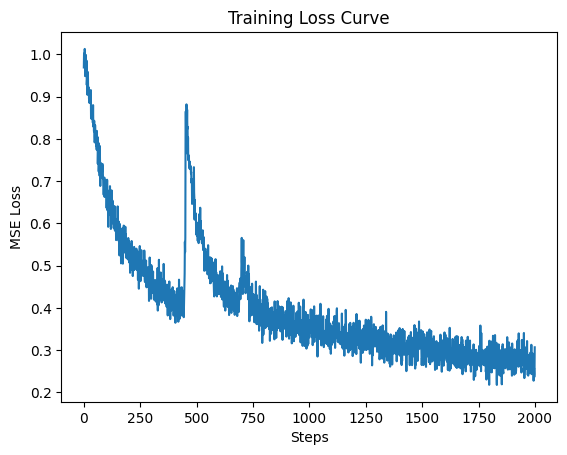

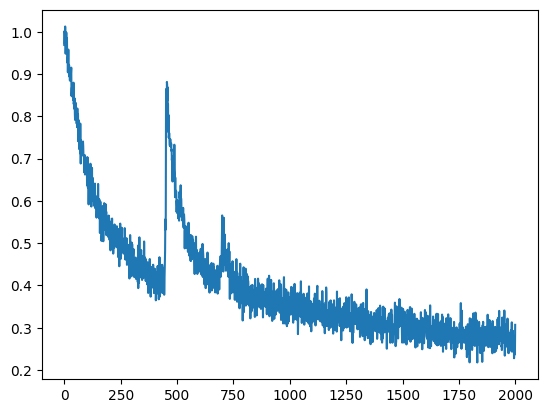

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# model = MelToEEG().to(device)
model = TemporalCNN_deep(80, eeg_train.shape[-1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 200
loss_curve = []

for epoch in range(epochs):
    model.train()
    running = 0

    for mel, eeg in train_loader:         
        # mel: (B, 300, 80)
        # eeg: (B, 300, 254)

        mel = mel.to(device)
        eeg = eeg.to(device)
        pred = model(mel)              # (B, 300, 254)

        loss = criterion(pred, eeg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()
        loss_curve.append(loss.item())
    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | Train Loss = {running/len(train_loader):.5f}")

plt.plot(loss_curve)
plt.xlabel("Steps")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.show()

CHECKPOINT_no_whisper = f"/home/shahed/SSIP/checkpoints/decoder_sub_{SUB_IDX}_no_whisper.pt"
torch.save(decoder.state_dict(), CHECKPOINT_no_whisper)

plt.plot(loss_curve)
np.save(f'/home/shahed/SSIP/loss_curves/sub_{SUB_IDX}_no_whisper.npy', np.array(loss_curve))


##### **Check train set predictions (randomly)**

2


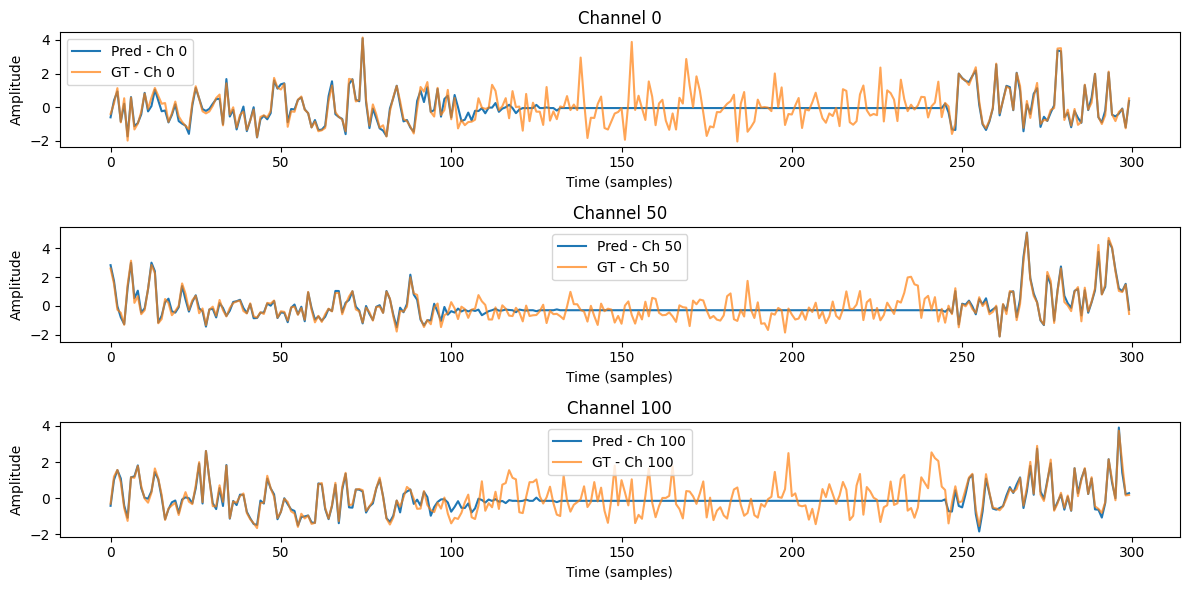

In [132]:
import matplotlib.pyplot as plt
import torch

def visualize_prediction(pred, eeg, sample_idx=0, channels=[0, 50, 100]):
    pred_np = pred[sample_idx].detach().cpu().numpy()   # (300, 254)
    eeg_np = eeg[sample_idx].detach().cpu().numpy()
    T = pred_np.shape[0]
    plt.figure(figsize=(12, 6))
    for i, ch in enumerate(channels):
        plt.subplot(len(channels), 1, i+1)
        plt.plot(pred_np[:, ch], label=f"Pred - Ch {ch}")
        plt.plot(eeg_np[:, ch], label=f"GT - Ch {ch}", alpha=0.7)
        plt.legend(); plt.xlabel("Time (samples)"); plt.ylabel("Amplitude"); plt.title(f"Channel {ch}")
    plt.tight_layout()
    plt.show()

total_batches = len(train_dataset)//len(train_loader)
batch_count = 0; random_batch = random.randint(0, total_batches) ## not sure how many
for mel, eeg in train_loader:  
    if batch_count == random_batch:  
        break
    mel = mel.to(device)
    eeg = eeg.to(device)
    pred = model(mel)   
    batch_count += 1
random_sample = random.randint(0, len(train_loader))
print(random_sample)
visualize_prediction(pred, eeg, sample_idx=random_sample, channels=[0, 50, 100])


##### **Check predictions on the test set**

In [ ]:
def pearson_corr_per_channel(pred, gt):
    # ensure shape (T, C)
    if pred.dim() == 3:
        pred = pred[0]
        gt   = gt[0]
    T, C = pred.shape; corrs = []
    for c in range(C):
        p = pred[:, c].detach().cpu().numpy()
        g = gt[:, c].detach().cpu().numpy()
        # Numerical stability
        if np.std(p) < 1e-6 or np.std(g) < 1e-6:
            corrs.append(np.nan)
            continue
        corr = np.corrcoef(p, g)[0, 1]
        corrs.append(corr)
    return np.array(corrs)

batch_idx = 0
all_corrs = []
for mel, eeg in test_loader:         
    mel = mel.to(device)
    eeg = eeg.to(device)
    pred = model(mel) 
    corrs = pearson_corr_per_channel(pred, eeg)
    mean_corr = np.nanmean(corrs)
    all_corrs.append(mean_corr)

    print(f"Mean Pearson correlation = {mean_corr:.4f}")
    print(f"Top 10% channel correlation = {np.nanmean(np.sort(corrs)[-int(0.1*eeg.shape[-1]):]):.4f}")

    print(f'batch idx : {batch_idx}')  
    visualize_prediction(pred, eeg, sample_idx=0, channels=[0, 50, 100])
    batch_idx += 1

print("\n======================")
print(f"Final test-set mean correlation = {np.nanmean(all_corrs):.4f}")
print("======================")

#### **compare whisper pre-trained results vs. no pretraining**

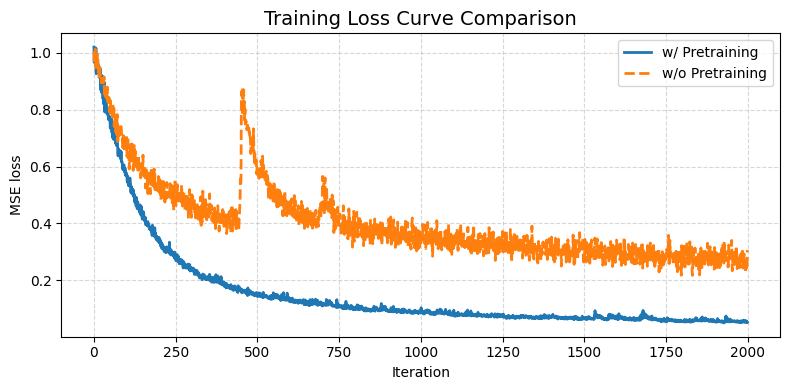

In [ ]:
pretrained_curve = np.load('/home/shahed/SSIP/loss_curves/sub_0_whisper.npy')
no_pretrained_curve = np.load('/home/shahed/SSIP/loss_curves/sub_0_no_whisper.npy')

plt.figure(figsize=(8,4))

plt.plot(pretrained_curve, label="w/ Pretraining", linewidth=2)
plt.plot(no_pretrained_curve, label="w/o Pretraining", linewidth=2, linestyle="--")

plt.title("Training Loss Curve Comparison", fontsize=14)
plt.xlabel("Iteration", fontsize=10)
plt.ylabel("MSE loss", fontsize=10)

plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig(f'/home/shahed/SSIP/loss_curves/comparison_sub_{SUB_IDX}.png')
